In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## MNIST mean = 0.1307 std = 0.3081 to be used in normalization
The normalization step helps the model to learn faster by ensuring that input values are centered around 0 and have roughly the same scale.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),   # scaling the data pixel/255 [0,1]
    transforms.Normalize((0.1307,), (0.3081,)) # normalizing the data (pixel-mean)/std
])

The MNIST dataset comes in two parts:

Training set: 60,000 images

Test set: 10,000 images

by setting train You're asking for the 60,000 training images.

In [5]:
data = datasets.MNIST(root= './data', download= False, train=True, transform= transform) # set download = True to download data for first time

In [6]:
img, _ = data[0]
print(img.shape, len(data))
type(data)

torch.Size([1, 28, 28]) 60000


torchvision.datasets.mnist.MNIST

In [7]:
X = data.data.numpy()   # (60,000, 28, 28)
Y = data.targets.numpy()  # (60,000)

In [8]:
x_train, x_, y_train,y_ = train_test_split(X, Y, test_size=0.4, random_state=1)
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.5, random_state=1)

DataLoader takes a dataset (like images, text, etc.) and gives you batches of data—this is especially useful when training models on large datasets that can’t fit into memory all at once.

So when DataLoader goes:
as in next steps

It knows how to:

- Get individual samples

- Group them into batches

- Shuffle them 

as the normal tensor can't do these processes


In [10]:
def create_Tensor_Data(X,Y):
    X_tensor = torch.tensor(X).unsqueeze(1).float() / 255.0    # add an extra dimension for the batch size
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    return TensorDataset(X_tensor, Y_tensor)

In [11]:
train_dataset = create_Tensor_Data(x_train, y_train)
val_dataset = create_Tensor_Data(x_cv, y_cv)
test_dataset = create_Tensor_Data(x_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

- epoch = 1 forward and backward pass of ALL training samples

- batch_size = number of training samples in one iteration

- number of iteration = number of passes, each pass using batch_size number of samples

e.g. 100 samples, batch_size = 20 ---> 100/20 = 5 iterations for 1 epoch

In [14]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()   # Why it matters:
                                        # nn.Module does important setup behind the scenes (registers layers, handles parameters, etc.).
                                        # If you forget to call super().__init__(), Your model will look like a regular Python class, not a PyTorch model.
        self.hl1 = nn.Linear(784, 256) 
        self.hl2 = nn.Linear(256, 128)
        self.hl3 = nn.Linear(128, 64)
        self.ol = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)       # Flattens 2D images into 1D vectors for input 
        x = F.relu(self.hl1(x))
        x = F.relu(self.hl2(x))
        x = F.relu(self.hl3(x))
        x = self.ol(x)
        return (x)

In [15]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

In [16]:
def train_model(model, train_loader, val_loader, lr, epochs=10):
    LCE = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad() # preventing accumulation clear the results calculated in the LCE.backward() step 
            output = model(x_batch)
            loss = LCE(output, y_batch)
            loss.backward()
            optimizer.step()    # update weights using the results calculated in the LCE.backward() step
            
            _, predicted = torch.max(output, 1) # return value, index parameters(tensor.vector, dim)
            train_correct += (predicted == y_batch).sum().item() #.item() to convert tensor value to int as (predicted and correct) are tensor values
            
            train_loss += loss.item() * x_batch.size(0) # As the LCE fun. return loss/64 
            total += y_batch.size(0)
            
        train_loss/=total
        train_correct/=total
        train_losses.append(train_loss)
        train_accuracies.append(train_correct)
        
        model.eval() # is a method used to set a PyTorch model to evaluation mode. It affects certain layers in the model that behave differently during training vs. evaluation.
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad(): # This tells PyTorch: “I'm just running the model to get predictions — no need to calculate or store gradients.”
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = LCE(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
    print("\n")
    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch 1/10, Train Loss: 2.2875, Train Acc: 0.1596, Val Loss: 2.2596, Val Acc: 0.2839
Epoch 2/10, Train Loss: 2.0906, Train Acc: 0.4628, Val Loss: 1.6907, Val Acc: 0.5539
Epoch 3/10, Train Loss: 1.0645, Train Acc: 0.7102, Val Loss: 0.7076, Val Acc: 0.7937
Epoch 4/10, Train Loss: 0.5846, Train Acc: 0.8291, Val Loss: 0.5108, Val Acc: 0.8537
Epoch 5/10, Train Loss: 0.4540, Train Acc: 0.8703, Val Loss: 0.4309, Val Acc: 0.8788
Epoch 6/10, Train Loss: 0.3916, Train Acc: 0.8888, Val Loss: 0.3869, Val Acc: 0.8901
Epoch 7/10, Train Loss: 0.3528, Train Acc: 0.8999, Val Loss: 0.3572, Val Acc: 0.8957
Epoch 8/10, Train Loss: 0.3250, Train Acc: 0.9069, Val Loss: 0.3331, Val Acc: 0.9048
Epoch 9/10, Train Loss: 0.3022, Train Acc: 0.9131, Val Loss: 0.3168, Val Acc: 0.9088
Epoch 10/10, Train Loss: 0.2827, Train Acc: 0.9196, Val Loss: 0.2989, Val Acc: 0.9125




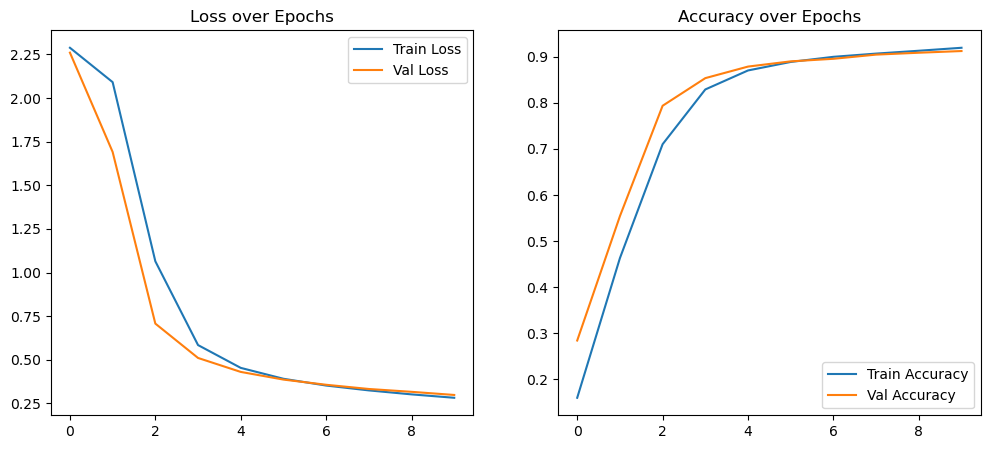

In [17]:
model = FeedForwardNN()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.01, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

With lr = 0.1:

Epoch 1/10, Train Loss: 0.8900, Train Acc: 0.7147, Val Loss: 0.3301, Val Acc: 0.9002
Epoch 2/10, Train Loss: 0.2404, Train Acc: 0.9271, Val Loss: 0.2232, Val Acc: 0.9333
Epoch 3/10, Train Loss: 0.1550, Train Acc: 0.9542, Val Loss: 0.1469, Val Acc: 0.9555
Epoch 4/10, Train Loss: 0.1129, Train Acc: 0.9658, Val Loss: 0.1401, Val Acc: 0.9581
Epoch 5/10, Train Loss: 0.0865, Train Acc: 0.9737, Val Loss: 0.1337, Val Acc: 0.9598
Epoch 6/10, Train Loss: 0.0684, Train Acc: 0.9794, Val Loss: 0.1357, Val Acc: 0.9603
Epoch 7/10, Train Loss: 0.0536, Train Acc: 0.9831, Val Loss: 0.1208, Val Acc: 0.9650
Epoch 8/10, Train Loss: 0.0434, Train Acc: 0.9868, Val Loss: 0.1080, Val Acc: 0.9693
Epoch 9/10, Train Loss: 0.0345, Train Acc: 0.9901, Val Loss: 0.1089, Val Acc: 0.9692
Epoch 10/10, Train Loss: 0.0261, Train Acc: 0.9923, Val Loss: 0.1060, Val Acc: 0.9719




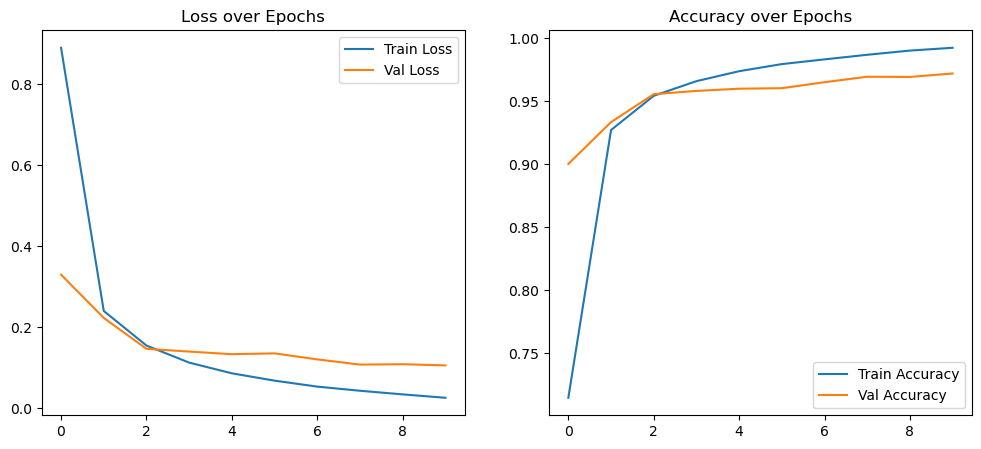

With lr = 0.001:

Epoch 1/10, Train Loss: 2.3042, Train Acc: 0.0992, Val Loss: 2.3030, Val Acc: 0.0956
Epoch 2/10, Train Loss: 2.3005, Train Acc: 0.0992, Val Loss: 2.2993, Val Acc: 0.0956
Epoch 3/10, Train Loss: 2.2967, Train Acc: 0.0992, Val Loss: 2.2955, Val Acc: 0.0956
Epoch 4/10, Train Loss: 2.2927, Train Acc: 0.0992, Val Loss: 2.2914, Val Acc: 0.0956
Epoch 5/10, Train Loss: 2.2884, Train Acc: 0.0992, Val Loss: 2.2869, Val Acc: 0.0956
Epoch 6/10, Train Loss: 2.2837, Train Acc: 0.0992, Val Loss: 2.2820, Val Acc: 0.0958
Epoch 7/10, Train Loss: 2.2785, Train Acc: 0.1004, Val Loss: 2.2764, Val Acc: 0.0981
Epoch 8/10, Train Loss: 2.2725, Train Acc: 0.1384, Val Loss: 2.2699, Val Acc: 0.1788
Epoch 9/10, Train Loss: 2.2653, Train Acc: 0.2236, Val Loss: 2.2620, Val Acc: 0.2522
Epoch 10/10, Train Loss: 2.2564, Train Acc: 0.2984, Val Loss: 2.2520, Val Acc: 0.3312




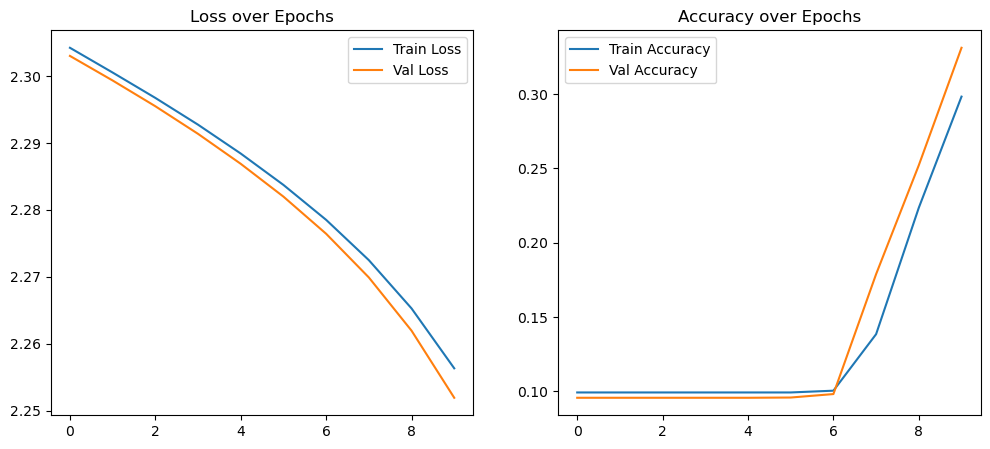

With lr = 0.03:

Epoch 1/10, Train Loss: 1.7931, Train Acc: 0.4513, Val Loss: 0.7207, Val Acc: 0.7728
Epoch 2/10, Train Loss: 0.4897, Train Acc: 0.8580, Val Loss: 0.4051, Val Acc: 0.8831
Epoch 3/10, Train Loss: 0.3524, Train Acc: 0.8981, Val Loss: 0.3576, Val Acc: 0.9002
Epoch 4/10, Train Loss: 0.2848, Train Acc: 0.9164, Val Loss: 0.2786, Val Acc: 0.9183
Epoch 5/10, Train Loss: 0.2328, Train Acc: 0.9317, Val Loss: 0.2427, Val Acc: 0.9287
Epoch 6/10, Train Loss: 0.1950, Train Acc: 0.9437, Val Loss: 0.2100, Val Acc: 0.9378
Epoch 7/10, Train Loss: 0.1660, Train Acc: 0.9515, Val Loss: 0.1822, Val Acc: 0.9467
Epoch 8/10, Train Loss: 0.1432, Train Acc: 0.9583, Val Loss: 0.1691, Val Acc: 0.9507
Epoch 9/10, Train Loss: 0.1256, Train Acc: 0.9631, Val Loss: 0.1588, Val Acc: 0.9533
Epoch 10/10, Train Loss: 0.1103, Train Acc: 0.9670, Val Loss: 0.1464, Val Acc: 0.9577




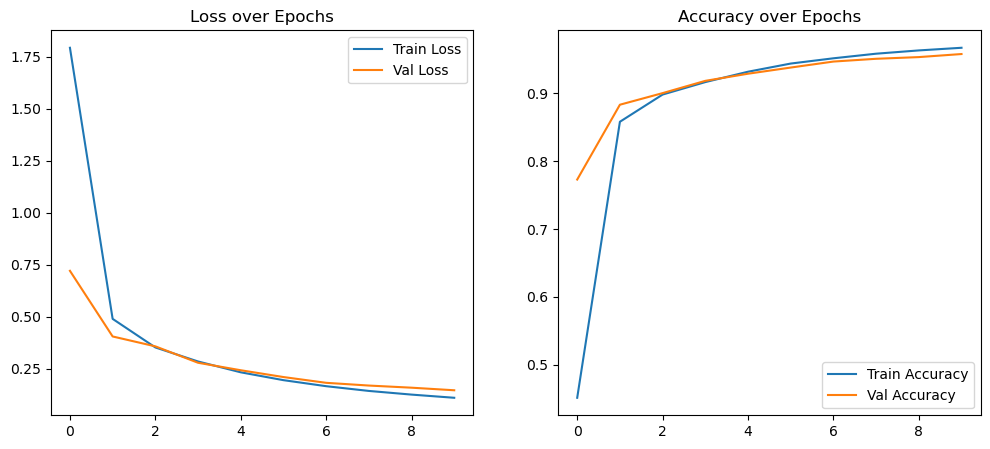

In [18]:
lrs = [0.1, 0.001, 0.03]
for lr in lrs:
    print(f"With lr = {lr}:\n")
    model = FeedForwardNN()
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, lr=lr, epochs=10)
    plot_metrics(train_loss, val_loss, train_acc, val_acc)

With batch_size = 16:

Epoch 1/10, Train Loss: 0.4161, Train Acc: 0.8676, Val Loss: 0.2035, Val Acc: 0.9372
Epoch 2/10, Train Loss: 0.1371, Train Acc: 0.9577, Val Loss: 0.1203, Val Acc: 0.9633
Epoch 3/10, Train Loss: 0.0930, Train Acc: 0.9701, Val Loss: 0.1059, Val Acc: 0.9673
Epoch 4/10, Train Loss: 0.0692, Train Acc: 0.9783, Val Loss: 0.1148, Val Acc: 0.9656
Epoch 5/10, Train Loss: 0.0523, Train Acc: 0.9833, Val Loss: 0.1133, Val Acc: 0.9680
Epoch 6/10, Train Loss: 0.0414, Train Acc: 0.9871, Val Loss: 0.0971, Val Acc: 0.9722
Epoch 7/10, Train Loss: 0.0328, Train Acc: 0.9895, Val Loss: 0.1055, Val Acc: 0.9704
Epoch 8/10, Train Loss: 0.0252, Train Acc: 0.9923, Val Loss: 0.1181, Val Acc: 0.9696
Epoch 9/10, Train Loss: 0.0234, Train Acc: 0.9926, Val Loss: 0.1030, Val Acc: 0.9758
Epoch 10/10, Train Loss: 0.0213, Train Acc: 0.9933, Val Loss: 0.1156, Val Acc: 0.9716




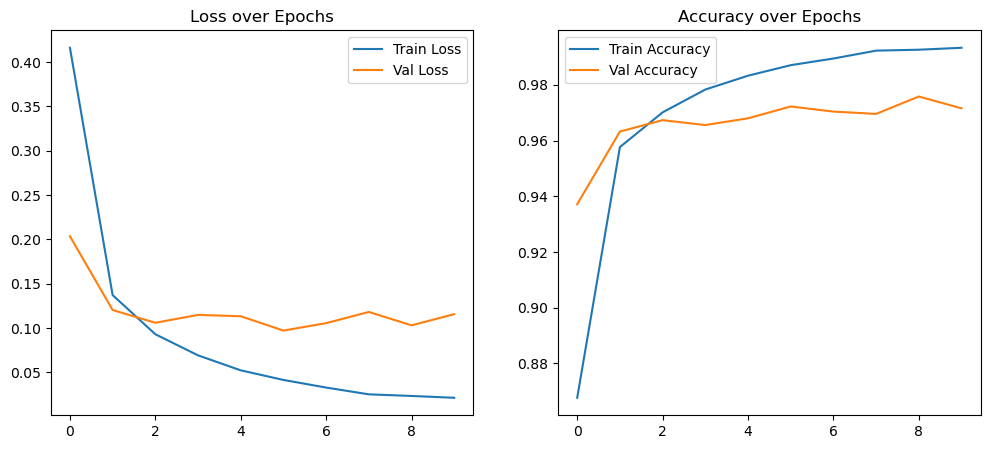

With batch_size = 128:

Epoch 1/10, Train Loss: 1.2655, Train Acc: 0.5906, Val Loss: 0.5068, Val Acc: 0.8354
Epoch 2/10, Train Loss: 0.3604, Train Acc: 0.8931, Val Loss: 0.3725, Val Acc: 0.8872
Epoch 3/10, Train Loss: 0.2466, Train Acc: 0.9268, Val Loss: 0.2563, Val Acc: 0.9217
Epoch 4/10, Train Loss: 0.1849, Train Acc: 0.9449, Val Loss: 0.1889, Val Acc: 0.9460
Epoch 5/10, Train Loss: 0.1444, Train Acc: 0.9571, Val Loss: 0.1568, Val Acc: 0.9527
Epoch 6/10, Train Loss: 0.1219, Train Acc: 0.9641, Val Loss: 0.1440, Val Acc: 0.9575
Epoch 7/10, Train Loss: 0.0985, Train Acc: 0.9709, Val Loss: 0.1394, Val Acc: 0.9579
Epoch 8/10, Train Loss: 0.0848, Train Acc: 0.9744, Val Loss: 0.1286, Val Acc: 0.9615
Epoch 9/10, Train Loss: 0.0717, Train Acc: 0.9785, Val Loss: 0.1249, Val Acc: 0.9630
Epoch 10/10, Train Loss: 0.0617, Train Acc: 0.9818, Val Loss: 0.1155, Val Acc: 0.9659




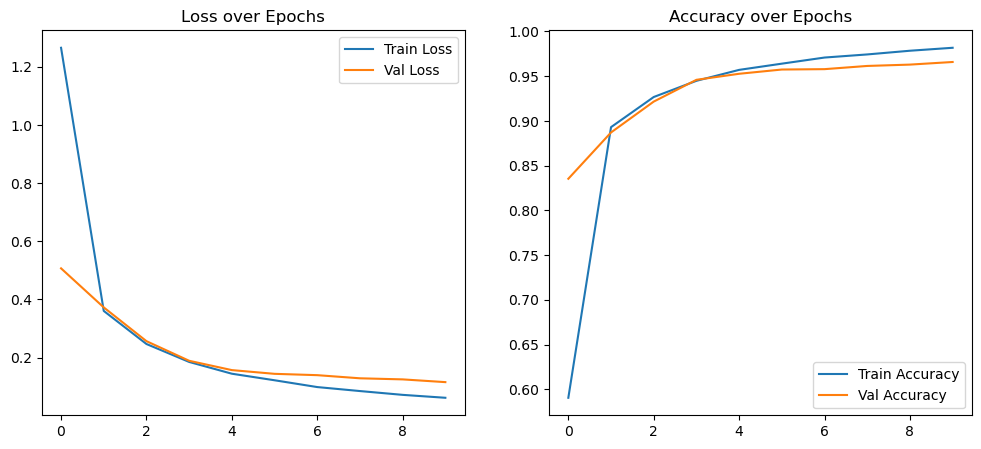

With batch_size = 256:

Epoch 1/10, Train Loss: 1.9744, Train Acc: 0.3814, Val Loss: 1.0458, Val Acc: 0.6282
Epoch 2/10, Train Loss: 0.6491, Train Acc: 0.7927, Val Loss: 0.4524, Val Acc: 0.8712
Epoch 3/10, Train Loss: 0.3947, Train Acc: 0.8837, Val Loss: 0.3883, Val Acc: 0.8842
Epoch 4/10, Train Loss: 0.3259, Train Acc: 0.9034, Val Loss: 0.3179, Val Acc: 0.9067
Epoch 5/10, Train Loss: 0.2710, Train Acc: 0.9195, Val Loss: 0.2697, Val Acc: 0.9199
Epoch 6/10, Train Loss: 0.2324, Train Acc: 0.9313, Val Loss: 0.2381, Val Acc: 0.9270
Epoch 7/10, Train Loss: 0.1954, Train Acc: 0.9418, Val Loss: 0.2067, Val Acc: 0.9386
Epoch 8/10, Train Loss: 0.1706, Train Acc: 0.9502, Val Loss: 0.1987, Val Acc: 0.9393
Epoch 9/10, Train Loss: 0.1503, Train Acc: 0.9554, Val Loss: 0.2025, Val Acc: 0.9392
Epoch 10/10, Train Loss: 0.1326, Train Acc: 0.9614, Val Loss: 0.1810, Val Acc: 0.9458




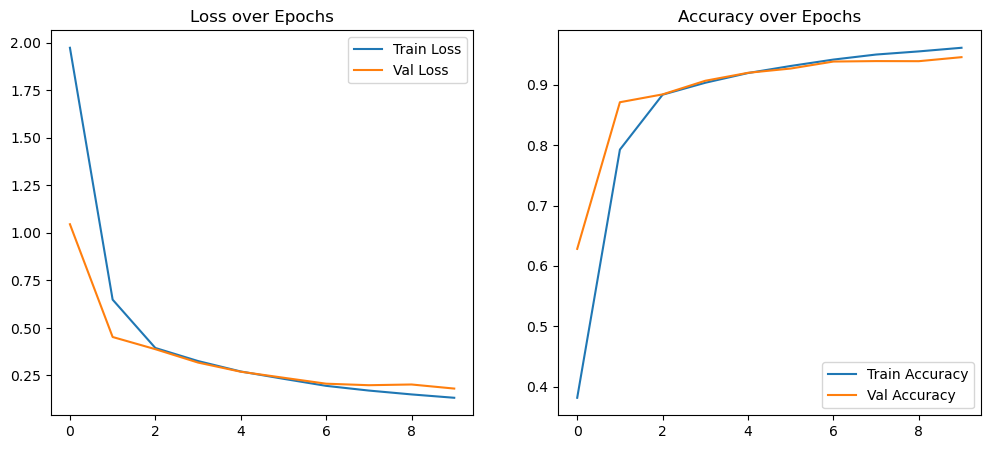

In [19]:
batch_sizes = [16, 128, 256]
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    print(f"With batch_size = {batch_size}:\n")
    model = FeedForwardNN()
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.1, epochs=10)
    plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

| Step | Layer                         | Output Shape        | Description                                                    |
|------|-------------------------------|---------------------|----------------------------------------------------------------|
| 0    | **Input**                     | [16, 1, 28, 28]     | Batch of 16 grayscale images (MNIST)                           |
| 1    | Conv2d(1 → 8, kernel=5)       | [16, 8, 24, 24]     | 8 filters, reduces size to 24×24 (no padding)                  |
| 2    | MaxPool2d(2×2)                | [16, 8, 12, 12]     | Downsamples each channel by a factor of 2                      |
| 3    | LayerNorm([8, 12, 12])        | [16, 8, 12, 12]     | Applies normalization over each feature map                   |
| 4    | Conv2d(8 → 16, kernel=5)      | [16, 16, 8, 8]      | 16 filters, reduces size to 8×8                                |
| 5    | MaxPool2d(2×2)                | [16, 16, 4, 4]      | Downsamples each channel by a factor of 2                      |
| 6    | LayerNorm([16, 4, 4])         | [16, 16, 4, 4]      | Normalizes again after 2nd pooling                            |
| 7    | Flatten                       | [16, 256]           | Flattens 16×4×4 to feed into fully connected layer             |
| 8    | Linear(256 → 32)              | [16, 32]            | First fully connected layer with 32 output units               |
| 9    | LayerNorm(32)                 | [16, 32]            | Normalizes the 32-dimensional output                          |
| 10   | Dropout                       | [16, 32]            | Randomly zeroes out features (during training)                 |
| 11   | Linear(32 → 10)               | [16, 10]            | Output logits for 10 classes (digits 0–9)                      |


In [22]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)    # (8, 24, 24)
        self.conv2 = nn.Conv2d(8, 16, 5)   # (16, 20, 20)
        self.ln1 = nn.LayerNorm([8, 12, 12])
        self.ln2 = nn.LayerNorm([16, 4, 4])
        self.fc1 = nn.Linear(256, 32)
        self.ln_fc = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))   # (8, 12, 12)
        x = self.ln1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))   # (16, 4, 4)
        x = self.ln2(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.ln_fc(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


Epoch 1/10, Train Loss: 0.4336, Train Acc: 0.8870, Val Loss: 0.1225, Val Acc: 0.9645
Epoch 2/10, Train Loss: 0.1695, Train Acc: 0.9576, Val Loss: 0.0813, Val Acc: 0.9759
Epoch 3/10, Train Loss: 0.1265, Train Acc: 0.9677, Val Loss: 0.0677, Val Acc: 0.9796
Epoch 4/10, Train Loss: 0.1091, Train Acc: 0.9713, Val Loss: 0.0601, Val Acc: 0.9806
Epoch 5/10, Train Loss: 0.0943, Train Acc: 0.9746, Val Loss: 0.0617, Val Acc: 0.9815
Epoch 6/10, Train Loss: 0.0831, Train Acc: 0.9781, Val Loss: 0.0536, Val Acc: 0.9840
Epoch 7/10, Train Loss: 0.0726, Train Acc: 0.9807, Val Loss: 0.0577, Val Acc: 0.9832
Epoch 8/10, Train Loss: 0.0690, Train Acc: 0.9818, Val Loss: 0.0546, Val Acc: 0.9840
Epoch 9/10, Train Loss: 0.0644, Train Acc: 0.9827, Val Loss: 0.0534, Val Acc: 0.9842
Epoch 10/10, Train Loss: 0.0599, Train Acc: 0.9837, Val Loss: 0.0527, Val Acc: 0.9838




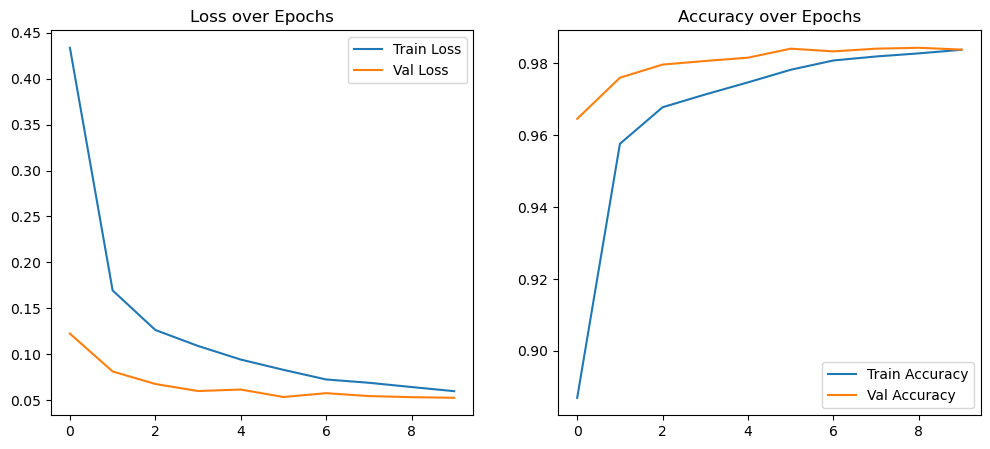

In [23]:
model = CNN1()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.01, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [24]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1/10, Train Loss: 0.3882, Train Acc: 0.8792, Val Loss: 0.1214, Val Acc: 0.9613
Epoch 2/10, Train Loss: 0.1729, Train Acc: 0.9476, Val Loss: 0.0837, Val Acc: 0.9735
Epoch 3/10, Train Loss: 0.1411, Train Acc: 0.9574, Val Loss: 0.0767, Val Acc: 0.9763
Epoch 4/10, Train Loss: 0.1276, Train Acc: 0.9604, Val Loss: 0.0775, Val Acc: 0.9770
Epoch 5/10, Train Loss: 0.1128, Train Acc: 0.9657, Val Loss: 0.0637, Val Acc: 0.9798
Epoch 6/10, Train Loss: 0.1093, Train Acc: 0.9667, Val Loss: 0.0781, Val Acc: 0.9764
Epoch 7/10, Train Loss: 0.1026, Train Acc: 0.9683, Val Loss: 0.0671, Val Acc: 0.9798
Epoch 8/10, Train Loss: 0.0970, Train Acc: 0.9696, Val Loss: 0.0812, Val Acc: 0.9738
Epoch 9/10, Train Loss: 0.0993, Train Acc: 0.9699, Val Loss: 0.0587, Val Acc: 0.9831
Epoch 10/10, Train Loss: 0.0900, Train Acc: 0.9724, Val Loss: 0.0567, Val Acc: 0.9817




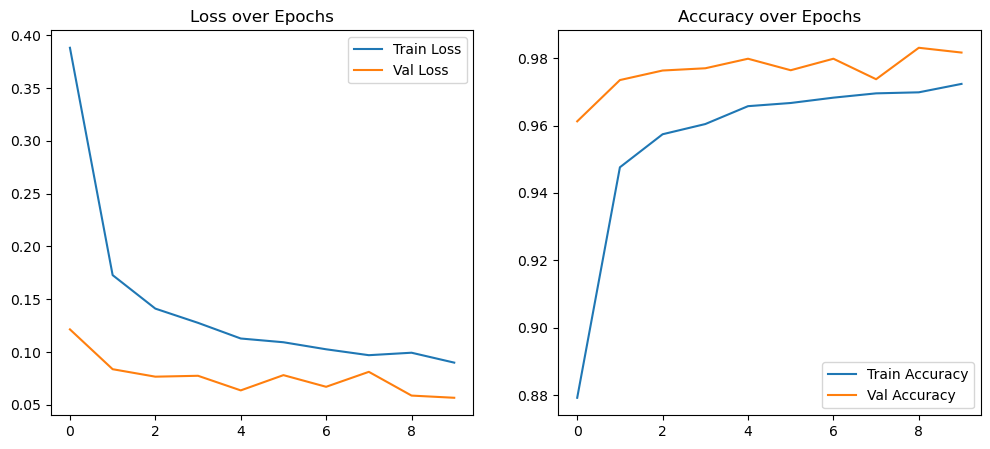

In [25]:
model = CNN2()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.1, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [26]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 1/10, Train Loss: 0.4060, Train Acc: 0.8668, Val Loss: 0.1011, Val Acc: 0.9674
Epoch 2/10, Train Loss: 0.1328, Train Acc: 0.9601, Val Loss: 0.0924, Val Acc: 0.9723
Epoch 3/10, Train Loss: 0.1014, Train Acc: 0.9700, Val Loss: 0.0691, Val Acc: 0.9804
Epoch 4/10, Train Loss: 0.0859, Train Acc: 0.9739, Val Loss: 0.0622, Val Acc: 0.9826
Epoch 5/10, Train Loss: 0.0767, Train Acc: 0.9774, Val Loss: 0.0549, Val Acc: 0.9825
Epoch 6/10, Train Loss: 0.0684, Train Acc: 0.9788, Val Loss: 0.0532, Val Acc: 0.9837
Epoch 7/10, Train Loss: 0.0591, Train Acc: 0.9832, Val Loss: 0.0561, Val Acc: 0.9841
Epoch 8/10, Train Loss: 0.0565, Train Acc: 0.9830, Val Loss: 0.0412, Val Acc: 0.9878
Epoch 9/10, Train Loss: 0.0530, Train Acc: 0.9842, Val Loss: 0.0421, Val Acc: 0.9866
Epoch 10/10, Train Loss: 0.0497, Train Acc: 0.9853, Val Loss: 0.0416, Val Acc: 0.9882




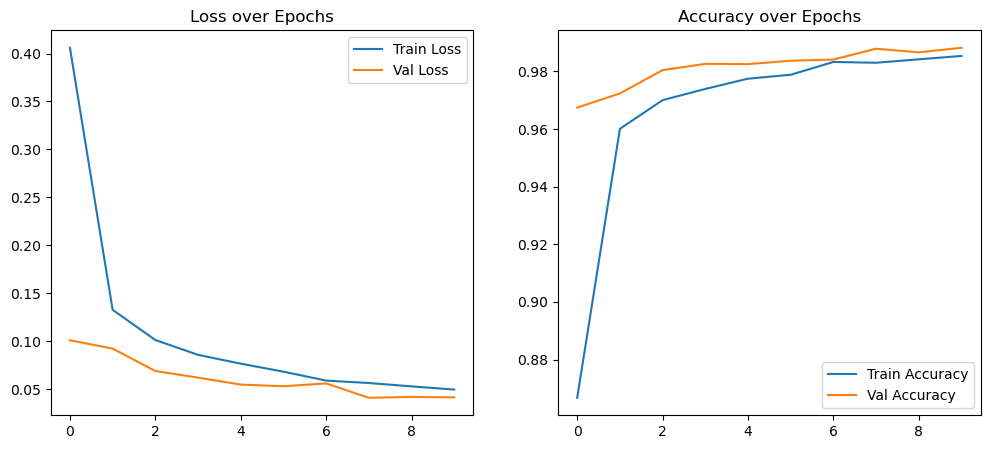

In [27]:
model = CNN3()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.1, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)      # -> (12, 24, 24)
        self.ln1 = nn.LayerNorm([12, 12, 12])             # After pooling

        self.conv2 = nn.Conv2d(12, 24, kernel_size=5)     # -> (24, 8, 8)
        self.ln2 = nn.LayerNorm([24, 4, 4])               # After pooling

        self.conv2_drop = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(24 * 4 * 4, 100)
        self.ln_fc1 = nn.LayerNorm(100)

        self.fc2 = nn.Linear(100, 50)
        self.fc2_drop = nn.Dropout(0.5)

        self.fc3 = nn.Linear(50, 25)
        self.ln_fc3 = nn.LayerNorm(25)

        self.fc4 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))        # (12, 12, 12)
        x = self.ln1(x)

        x = F.relu(F.max_pool2d(self.conv2(x), 2))        # (24, 4, 4)
        x = self.conv2_drop(x)
        x = self.ln2(x)

        x = x.view(-1, 24 * 4 * 4)                         # (384)
        x = F.relu(self.fc1(x))
        x = self.ln_fc1(x)

        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)

        x = F.relu(self.fc3(x))
        x = self.ln_fc3(x)

        x = self.fc4(x)
        return x


Epoch 1/10, Train Loss: 0.3935, Train Acc: 0.8809, Val Loss: 0.1235, Val Acc: 0.9680
Epoch 2/10, Train Loss: 0.1553, Train Acc: 0.9604, Val Loss: 0.0877, Val Acc: 0.9778
Epoch 3/10, Train Loss: 0.1257, Train Acc: 0.9673, Val Loss: 0.0704, Val Acc: 0.9815
Epoch 4/10, Train Loss: 0.1007, Train Acc: 0.9748, Val Loss: 0.0795, Val Acc: 0.9812
Epoch 5/10, Train Loss: 0.0953, Train Acc: 0.9760, Val Loss: 0.0630, Val Acc: 0.9849
Epoch 6/10, Train Loss: 0.0763, Train Acc: 0.9802, Val Loss: 0.0602, Val Acc: 0.9864
Epoch 7/10, Train Loss: 0.0778, Train Acc: 0.9795, Val Loss: 0.0526, Val Acc: 0.9882
Epoch 8/10, Train Loss: 0.0657, Train Acc: 0.9826, Val Loss: 0.0511, Val Acc: 0.9878
Epoch 9/10, Train Loss: 0.0634, Train Acc: 0.9836, Val Loss: 0.0538, Val Acc: 0.9869
Epoch 10/10, Train Loss: 0.0639, Train Acc: 0.9841, Val Loss: 0.0559, Val Acc: 0.9866




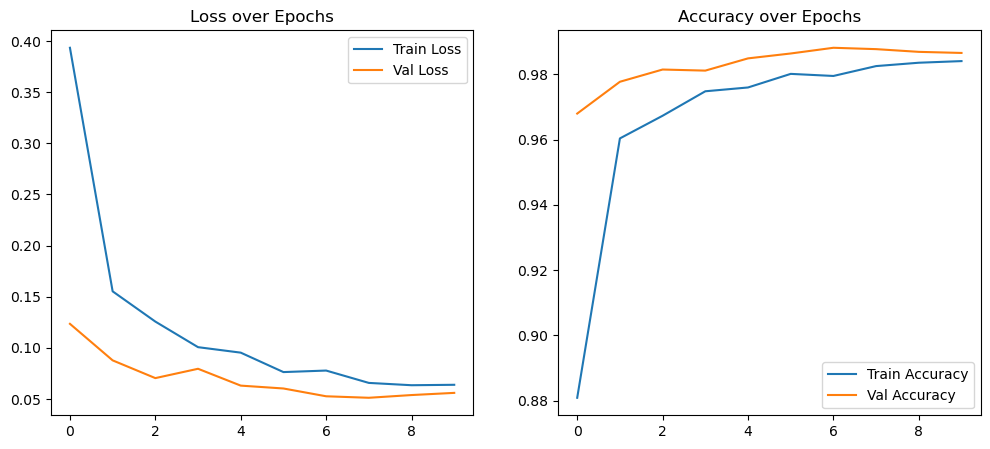

In [29]:
model = CNN4()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.1, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Epoch 1/10, Train Loss: 0.3722, Train Acc: 0.8792, Val Loss: 0.1011, Val Acc: 0.9697
Epoch 2/10, Train Loss: 0.1221, Train Acc: 0.9641, Val Loss: 0.0694, Val Acc: 0.9783
Epoch 3/10, Train Loss: 0.0952, Train Acc: 0.9723, Val Loss: 0.0548, Val Acc: 0.9832
Epoch 4/10, Train Loss: 0.0733, Train Acc: 0.9778, Val Loss: 0.0539, Val Acc: 0.9849
Epoch 5/10, Train Loss: 0.0733, Train Acc: 0.9778, Val Loss: 0.0560, Val Acc: 0.9831
Epoch 6/10, Train Loss: 0.0608, Train Acc: 0.9819, Val Loss: 0.0443, Val Acc: 0.9872
Epoch 7/10, Train Loss: 0.0547, Train Acc: 0.9831, Val Loss: 0.0479, Val Acc: 0.9858
Epoch 8/10, Train Loss: 0.0511, Train Acc: 0.9845, Val Loss: 0.0512, Val Acc: 0.9868
Epoch 9/10, Train Loss: 0.0482, Train Acc: 0.9854, Val Loss: 0.0384, Val Acc: 0.9879
Epoch 10/10, Train Loss: 0.0460, Train Acc: 0.9860, Val Loss: 0.0394, Val Acc: 0.9888




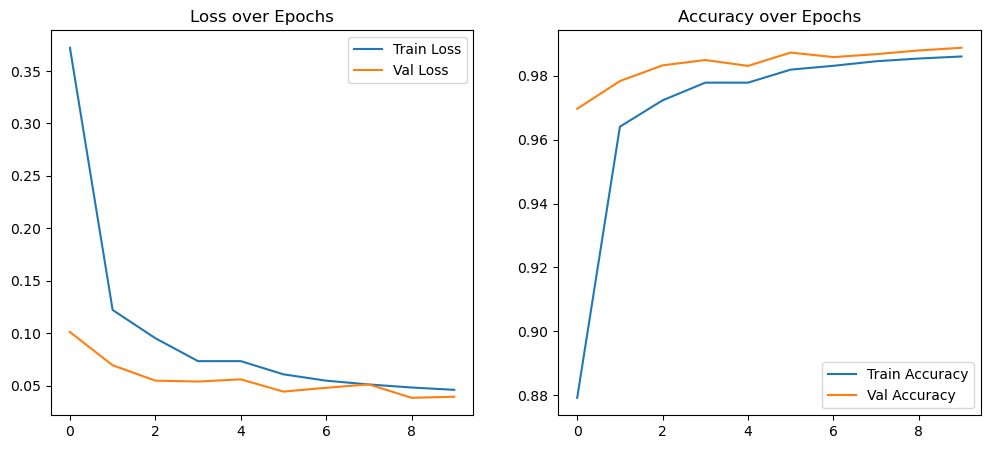

In [30]:
model = CNN3()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.1, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [31]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {acc:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


Test Accuracy: 0.9887


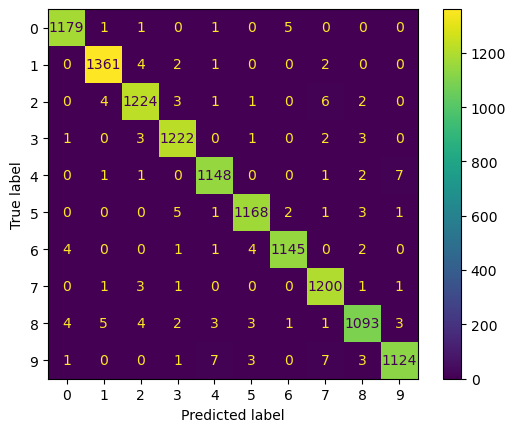

In [32]:
evaluate_model(model, test_loader)